# Model Development
In this notebook, I will join the ACCIDENT, ATMOSPHERIC_COND after imputed, LIGHT_CONDITION after imputed, Person after aggregated,  ROAD_SURFACE_COND after imputed, SPEED_ZONE after imputed as the training data.
Implementing XGBoost model for its gradient boosting, handles imbalance and non-linearity well, and SHAP values to check the feature contribution, revealing global impacts.

### Data Preparation
Merge the related files and formalize the format for the training

In [1]:
import numpy as np
import pandas as pd
import shap
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import balanced_accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import warnings

# Suppress all UserWarnings
warnings.filterwarnings("ignore", category=UserWarning)
# Load the all the dataset from Dataset folder
def load_dataset(file_name):
    return pd.read_csv(f'Clean-data/{file_name}', low_memory=False)

file_list = [
    'ACCIDENT.csv',
    'ATMOSPHERIC_COND_IMPUTED.csv',
    'LIGHT_CONDITION_IMPUTED.csv',
    'PERSON_agg_by_ACCIDENT.csv',
    'ROAD_SURFACE_COND_IMPUTED.csv',
    'SPEED_ZONE_IMPUTED.csv',
]
# Load all datasets into a dictionary
datasets = {file_name.split('.')[0]: load_dataset(file_name) for file_name in file_list}
# Save the datasets to a dictionary for further processing
datasets = {
    'ACCIDENT': load_dataset('ACCIDENT.csv'),
    'ATMOSPHERIC_COND_IMPUTED': load_dataset('ATMOSPHERIC_COND_IMPUTED.csv'),
    'LIGHT_CONDITION_IMPUTED': load_dataset('LIGHT_CONDITION_IMPUTED.csv'),
    'PERSON_agg_by_ACCIDENT': load_dataset('PERSON_agg_by_ACCIDENT.csv'),
    'ROAD_SURFACE_COND_IMPUTED': load_dataset('ROAD_SURFACE_COND_IMPUTED.csv'),
    'SPEED_ZONE_IMPUTED': load_dataset('SPEED_ZONE_IMPUTED.csv'),
}

In [4]:
# Check all the datasets shape and missing values
for name, df in datasets.items():
    print(f"{name}: {df.shape}, Missing values: {df.isnull().sum().sum()}")

ACCIDENT: (203708, 28), Missing values: 11740
ATMOSPHERIC_COND_IMPUTED: (203708, 3), Missing values: 0
LIGHT_CONDITION_IMPUTED: (203708, 3), Missing values: 0
PERSON_agg_by_ACCIDENT: (203708, 2), Missing values: 4533
ROAD_SURFACE_COND_IMPUTED: (203708, 3), Missing values: 0
SPEED_ZONE_IMPUTED: (203708, 2), Missing values: 0


In [5]:
acc = datasets['ACCIDENT']
acc.head()

,ACCIDENT_NO,ACCIDENTDATE,ACCIDENTTIME,ACCIDENT_TYPE,Accident Type Desc,DAY_OF_WEEK,Day Week Description,DCA_CODE,DCA Description,DIRECTORY,...,NO_PERSONS,NO_PERSONS_INJ_2,NO_PERSONS_INJ_3,NO_PERSONS_KILLED,NO_PERSONS_NOT_INJ,POLICE_ATTEND,ROAD_GEOMETRY,Road Geometry Desc,SEVERITY,SPEED_ZONE
0,T20060000010,13/01/2006,12:42:00,1,Collision with vehicle,6,Friday,113,RIGHT NEAR (INTERSECTIONS ONLY),MEL,...,6,0,1,0,5,1,1,Cross intersection,3,60
1,T20060000018,13/01/2006,19:10:00,1,Collision with vehicle,6,Friday,113,RIGHT NEAR (INTERSECTIONS ONLY),MEL,...,4,0,1,0,3,1,2,T intersection,3,70
2,T20060000022,14/01/2006,12:10:00,7,Fall from or in moving vehicle,7,Saturday,190,FELL IN/FROM VEHICLE,MEL,...,2,1,0,0,1,1,5,Not at intersection,2,100
3,T20060000023,14/01/2006,11:49:00,1,Collision with vehicle,7,Saturday,130,REAR END(VEHICLES IN SAME LANE),MEL,...,2,1,0,0,1,1,2,T intersection,2,80
4,T20060000026,14/01/2006,10:45:00,1,Collision with vehicle,7,Saturday,121,RIGHT THROUGH,MEL,...,3,0,3,0,0,1,5,Not at intersection,3,50


In [6]:
acc.drop(columns=['DIRECTORY', 'EDITION', 'PAGE', 'GRID_REFERENCE_X', 'GRID_REFERENCE_Y'], inplace=True)

In [7]:
# Get the Hour and Month per accident, assign Fri-Mon as 'weekend'
acc['ACCIDENT_TIME_HOUR'] = pd.to_datetime(acc['ACCIDENTTIME']).dt.hour
acc['ACCIDENT_TIME_MONTH'] = pd.to_datetime(acc['ACCIDENTDATE']).dt.month
acc['IS_WEEKEND'] = acc['DAY_OF_WEEK'].apply(lambda x: 1 if x in [6,7,0,1] else 0)

In [8]:
acc.head()

,ACCIDENT_NO,ACCIDENTDATE,ACCIDENTTIME,ACCIDENT_TYPE,Accident Type Desc,DAY_OF_WEEK,Day Week Description,DCA_CODE,DCA Description,LIGHT_CONDITION,...,NO_PERSONS_KILLED,NO_PERSONS_NOT_INJ,POLICE_ATTEND,ROAD_GEOMETRY,Road Geometry Desc,SEVERITY,SPEED_ZONE,ACCIDENT_TIME_HOUR,ACCIDENT_TIME_MONTH,IS_WEEKEND
0,T20060000010,13/01/2006,12:42:00,1,Collision with vehicle,6,Friday,113,RIGHT NEAR (INTERSECTIONS ONLY),1,...,0,5,1,1,Cross intersection,3,60,12,1,1
1,T20060000018,13/01/2006,19:10:00,1,Collision with vehicle,6,Friday,113,RIGHT NEAR (INTERSECTIONS ONLY),1,...,0,3,1,2,T intersection,3,70,19,1,1
2,T20060000022,14/01/2006,12:10:00,7,Fall from or in moving vehicle,7,Saturday,190,FELL IN/FROM VEHICLE,1,...,0,1,1,5,Not at intersection,2,100,12,1,1
3,T20060000023,14/01/2006,11:49:00,1,Collision with vehicle,7,Saturday,130,REAR END(VEHICLES IN SAME LANE),1,...,0,1,1,2,T intersection,2,80,11,1,1
4,T20060000026,14/01/2006,10:45:00,1,Collision with vehicle,7,Saturday,121,RIGHT THROUGH,1,...,0,0,1,5,Not at intersection,3,50,10,1,1


In [9]:
# merge all the file together
def merge_datasets(datasets):
    merged_df = datasets['ACCIDENT']
    for name, df in datasets.items():
        if name != 'ACCIDENT':
            merged_df = merged_df.merge(df, on='ACCIDENT_NO', how='left')
    return merged_df
merged_df = merge_datasets(datasets)

In [10]:
merged_df.shape

(203708, 34)

In [11]:
merged_df.head()

,ACCIDENT_NO,ACCIDENTDATE,ACCIDENTTIME,ACCIDENT_TYPE,Accident Type Desc,DAY_OF_WEEK,Day Week Description,DCA_CODE,DCA Description,LIGHT_CONDITION_x,...,ACCIDENT_TIME_MONTH,IS_WEEKEND,ATMOSPH_COND,Atmosph Cond Desc,LIGHT_CONDITION_y,Light Condition Desc_y,OPERATOR_MEDIAN_AGE,SURFACE_COND,Surface Cond Desc,SPEED_ZONE_y
0,T20060000010,13/01/2006,12:42:00,1,Collision with vehicle,6,Friday,113,RIGHT NEAR (INTERSECTIONS ONLY),1,...,1,1,1,Clear,1,Day,62.0,1.0,Dry,60.0
1,T20060000018,13/01/2006,19:10:00,1,Collision with vehicle,6,Friday,113,RIGHT NEAR (INTERSECTIONS ONLY),1,...,1,1,1,Clear,1,Day,25.0,1.0,Dry,70.0
2,T20060000022,14/01/2006,12:10:00,7,Fall from or in moving vehicle,7,Saturday,190,FELL IN/FROM VEHICLE,1,...,1,1,1,Clear,1,Day,45.0,1.0,Dry,100.0
3,T20060000023,14/01/2006,11:49:00,1,Collision with vehicle,7,Saturday,130,REAR END(VEHICLES IN SAME LANE),1,...,1,1,1,Clear,1,Day,42.5,1.0,Dry,80.0
4,T20060000026,14/01/2006,10:45:00,1,Collision with vehicle,7,Saturday,121,RIGHT THROUGH,1,...,1,1,1,Clear,1,Day,67.5,1.0,Dry,50.0


In [12]:
# Check the columns in the merged dataset
print("Columns in the merged dataset:") 
print(merged_df.columns.tolist())

Columns in the merged dataset:
['ACCIDENT_NO', 'ACCIDENTDATE', 'ACCIDENTTIME', 'ACCIDENT_TYPE', 'Accident Type Desc', 'DAY_OF_WEEK', 'Day Week Description', 'DCA_CODE', 'DCA Description', 'LIGHT_CONDITION_x', 'Light Condition Desc_x', 'NODE_ID', 'NO_OF_VEHICLES', 'NO_PERSONS', 'NO_PERSONS_INJ_2', 'NO_PERSONS_INJ_3', 'NO_PERSONS_KILLED', 'NO_PERSONS_NOT_INJ', 'POLICE_ATTEND', 'ROAD_GEOMETRY', 'Road Geometry Desc', 'SEVERITY', 'SPEED_ZONE_x', 'ACCIDENT_TIME_HOUR', 'ACCIDENT_TIME_MONTH', 'IS_WEEKEND', 'ATMOSPH_COND', 'Atmosph Cond Desc', 'LIGHT_CONDITION_y', 'Light Condition Desc_y', 'OPERATOR_MEDIAN_AGE', 'SURFACE_COND', 'Surface Cond Desc', 'SPEED_ZONE_y']


In [13]:
# Drop the original columns that have been imputed
merged_df.drop(['LIGHT_CONDITION_x', 'SPEED_ZONE_x', 'Light Condition Desc_x'], axis=1, inplace=True)

In [14]:
# rename columns for clarity
merged_df.rename(columns={
    'LIGHT_CONDITION_y': 'LIGHT_CONDITION',
    'SPEED_ZONE_y': 'SPEED_ZONE',
    'Light Condition Desc_y': 'Light Condition Desc',
}, inplace=True)

In [13]:
# Save the merged dataset to a CSV file
merged_df.to_csv('Clean-data/merged_dataset.csv', index=False)

### Model Training

In [2]:
df = pd.read_csv("Clean-data/merged_dataset.csv", low_memory=False)
TARGET = "SEVERITY"
feature_cols = [
    'Day Week Description','LIGHT_CONDITION','SPEED_ZONE',
    'ACCIDENT_TIME_HOUR','ACCIDENT_TIME_MONTH','IS_WEEKEND',
    'ATMOSPH_COND','SURFACE_COND','OPERATOR_MEDIAN_AGE'
]
feature_cols = [c for c in feature_cols if c in df.columns]
# Drop the target column
df = df[df[TARGET].notna()].copy()
# Encode target started with 0
le = LabelEncoder()
y_enc = le.fit_transform(df[TARGET])
print("Label mapping:", dict(zip(le.classes_, range(len(le.classes_)))))

# Split the training and validation set 80/20
X = df[feature_cols].copy()
X_train, X_validate, y_train, y_validate = train_test_split(X, y_enc, test_size=0.2, random_state=42)
# Preprocess (One-hot encoding for category columns, remain columns which non-category exactly they are )
num_features = [c for c in feature_cols if pd.api.types.is_numeric_dtype(df[c])]
cat_features = [c for c in feature_cols if c not in num_features]
prep = ColumnTransformer(
    transformers=[("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_features)],
    remainder="passthrough"
)

# Train with early stopping
prep.fit(X_train)
Xtr = prep.transform(X_train)
Xva = prep.transform(X_validate)

# Automatically handles missing values, since there are some missing in the avg_operator_age
dtrain = xgb.DMatrix(Xtr, label=y_train)
dvalid = xgb.DMatrix(Xva, label=y_validate)
params = {
    "objective": "multi:softprob",
    "num_class": len(le.classes_),
    "eval_metric": "mlogloss",
    "eta": 0.05,
    "max_depth": 6,
    "min_child_weight": 2,
    "subsample": 0.9,
    "colsample_bytree": 0.8,
    "lambda": 1.0,
    "tree_method": "hist",
    'device': 'gpu',
    "seed": 42,
}

booster = xgb.train(
    params, dtrain,
    num_boost_round=2000,
    evals=[(dtrain,"train"), (dvalid,"valid")],
    early_stopping_rounds=50,
    verbose_eval=False
)

# Evaluate
y_prediction = np.argmax(booster.predict(dvalid, iteration_range=(0, booster.best_iteration+1)), axis=1)

print("Balanced accuracy:", round(balanced_accuracy_score(y_validate, y_prediction), 4))
print("F1 macro:", round(f1_score(y_validate, y_prediction, average='macro'), 4))
print("Confusion matrix:\n", confusion_matrix(y_validate, y_prediction))
print("\nClassification report:\n", classification_report(y_validate, y_prediction))


Label mapping: {np.int64(1): 0, np.int64(2): 1, np.int64(3): 2, np.int64(4): 3}
Balanced accuracy: 0.2647
F1 macro: 0.2407
Confusion matrix:
 [[    1   190   561     0]
 [    0  1546 12196     0]
 [    0  1442 24805     0]
 [    0     0     1     0]]

Classification report:
               precision    recall  f1-score   support

           0       1.00      0.00      0.00       752
           1       0.49      0.11      0.18     13742
           2       0.66      0.95      0.78     26247
           3       0.00      0.00      0.00         1

    accuracy                           0.65     40742
   macro avg       0.54      0.26      0.24     40742
weighted avg       0.61      0.65      0.56     40742


### Evaluate the feature importance

                           feature  importance
0                       SPEED_ZONE    7.085172
1                  LIGHT_CONDITION    5.133157
2               ACCIDENT_TIME_HOUR    2.575880
3      Day Week Description_Sunday    2.464640
4                       IS_WEEKEND    2.405156
5              OPERATOR_MEDIAN_AGE    2.268200
6    Day Week Description_Saturday    2.100490
7      Day Week Description_Monday    2.002478
8      Day Week Description_Friday    1.893016
9                     SURFACE_COND    1.566349
10             ACCIDENT_TIME_MONTH    1.459789
11                    ATMOSPH_COND    1.440022
12  Day Week Description_Wednesday    1.359465
13    Day Week Description_Tuesday    1.356271
14   Day Week Description_Thursday    1.351852


<Axes: xlabel='feature'>

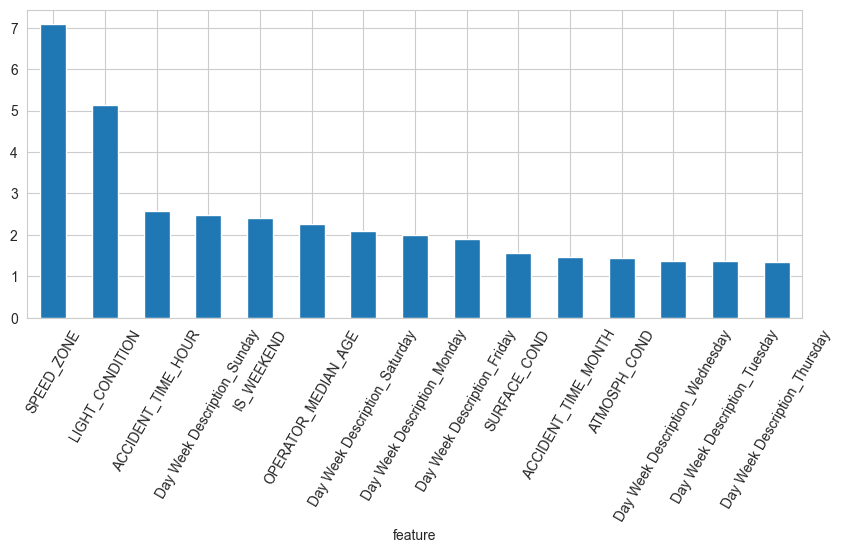

In [3]:
# Get final feature names from the fitted ColumnTransformer
cat_names = prep.named_transformers_["cat"].get_feature_names_out(cat_features) if cat_features else np.array([])
feature_names = np.array(list(cat_names) + num_features)
# Get importance from booster
raw_importance = booster.get_score(importance_type="gain")  
# Map to real feature names
pairs = []
for k, v in raw_importance.items():
    idx = int(k[1:])  # drop the 'f'
    pairs.append((feature_names[idx], v))

feat_importance = (
    pd.DataFrame(pairs, columns=["feature", "importance"])
    .sort_values("importance", ascending=False)
    .reset_index(drop=True)
)
# Print Top 20
print(feat_importance.head(20))
# Plot Top 20
feat_importance.head(20).plot.bar(x="feature", y="importance", figsize=(10, 4), legend=False, rot=60)

In [4]:
# SHAP
# Get the features names
feature_names = np.array(prep.get_feature_names_out())
# Compute SHAP values
explainer = shap.TreeExplainer(booster)
sv = explainer.shap_values(Xva)  # may be list or ndarray with shape (N,F,K) or (N,K,F) or (N,F)

# Normalize SHAP shape to (N, F, K)
def to_nfk(sv):
    if isinstance(sv, list):
        arr = np.stack(sv, axis=0)  # (K, N, F)
        return np.transpose(arr, (1, 2, 0))  # (N, F, K)
    sv = np.asarray(sv)
    if sv.ndim == 3:
        N, A, B = sv.shape
        if A == Xva.shape[1]:  # (N, F, K)
            return sv
        elif B == Xva.shape[1]:  # (N, K, F) -> (N, F, K)
            return np.transpose(sv, (0, 2, 1))
    elif sv.ndim == 2:  # binary classification
        return sv[:, :, None]
    raise RuntimeError(f"Unexpected SHAP shape: {sv.shape}")

sv_nfk = to_nfk(sv)  # (N, F, K)

# importance value function
def per_value_overall_importance(Xmat, sv_nfk, col_idx, feature_name):
    per_sample_mean_abs = np.abs(sv_nfk[:, col_idx, :]).mean(axis=1)  # (N,)
    vals = Xmat[:, col_idx]
    df = (pd.DataFrame({"value": vals, "abs_shap": per_sample_mean_abs})
          .groupby("value", dropna=False)
          .agg(mean_abs_shap=("abs_shap", "mean"),
               count=("abs_shap", "size"))
          .sort_values("mean_abs_shap", ascending=False)
          .reset_index())
    return df

# Loop through features and print top values
TOP_N = 8
for i, fname in enumerate(feature_names):
    df_imp = per_value_overall_importance(Xva, sv_nfk, i, fname)
    print(f"\n=== {fname} — Top {TOP_N} values by mean|SHAP| ===")
    print(df_imp.head(TOP_N).to_string(index=False))



=== cat__Day Week Description_Friday — Top 8 values by mean|SHAP| ===
 value  mean_abs_shap  count
   1.0       0.027861   6575
   0.0       0.006429  34167

=== cat__Day Week Description_Monday — Top 8 values by mean|SHAP| ===
 value  mean_abs_shap  count
   1.0       0.024001   5446
   0.0       0.004585  35296

=== cat__Day Week Description_Saturday — Top 8 values by mean|SHAP| ===
 value  mean_abs_shap  count
   1.0       0.033354   5750
   0.0       0.006085  34992

=== cat__Day Week Description_Sunday — Top 8 values by mean|SHAP| ===
 value  mean_abs_shap  count
   1.0       0.038326   5024
   0.0       0.005657  35718

=== cat__Day Week Description_Thursday — Top 8 values by mean|SHAP| ===
 value  mean_abs_shap  count
   1.0       0.008923   6118
   0.0       0.001555  34624

=== cat__Day Week Description_Tuesday — Top 8 values by mean|SHAP| ===
 value  mean_abs_shap  count
   1.0       0.010152   5830
   0.0       0.001503  34912

=== cat__Day Week Description_Wednesday — Top 